In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import math


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report

from PIL import Image



In [3]:

class Encoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim):
        super(Encoder, self).__init__()
        # define convolutional layers
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # variable to store the shape of the output tensor before flattening
        # the features, it will be used in decoders input while reconstructing
        self.shape_before_flattening = None
        # compute the flattened size after convolutions
        flattened_size = (image_size // 8) * (image_size // 8) * 128
        # define fully connected layer to create embeddings
        self.fc = nn.Linear(flattened_size, embedding_dim)
    def forward(self, x):
        # apply ReLU activations after each convolutional layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # store the shape before flattening
        self.shape_before_flattening = x.shape[1:]
        # flatten the tensor
        x = x.view(x.size(0), -1)
        # apply fully connected layer to generate embeddings
        x = self.fc(x)
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        # define fully connected layer to unflatten the embeddings
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        # store the shape before flattening
        self.reshape_dim = shape_before_flattening
        # define transpose convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        # define final convolutional layer to generate output image
        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        # apply fully connected layer to unflatten the embeddings
        x = self.fc(x)
        # reshape the tensor to match shape before flattening
        x = x.view(x.size(0), *self.reshape_dim)
        # apply ReLU activations after each transpose convolutional layer
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        # apply sigmoid activation to the final convolutional layer to generate output image
        x = torch.sigmoid(self.conv1(x))
        return x

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ImageDataset(Dataset):
    def __init__(self, image_dir, label_path, indexes):
        if label_path != None
            label = pd.read_csv(label_path)
            label = label.drop(columns=['Unnamed: 0'])
            self.labels_and_names = label
        self.image_dir = image_dir
        self.indexes = indexes

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, iteridx):
        idx = int(self.indexes[iteridx])
        if torch.is_tensor(idx):
            idx = idx.tolist()
        name = self.labels_and_names['id'][idx]
        pilImage = Image.open(f"{self.image_dir}/{name}.jpg")
        image = transform(pilImage)
        label = self.labels_and_names['label'][idx]

        return (image, label)


In [12]:
dataset_size = 300
batch_size_train = 100
batch_size_train
train_size = math.floor(dataset_size//3)
indexes = np.arange(dataset_size)
train_idx, test_idx = train_test_split(indexes, train_size=train_size, random_state=925)

train_dataset = ImageDataset("enc_ims", "dataset_work/labels/image_only/alice_train_personalityFalse_imageTrue_labels.csv", train_idx)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size_train, shuffle=True)



In [14]:
def train_loop(dataloader, encoder, decoder, loss_fn, optimizer, writer=None, epoch=0):
    for i in range(10):
        print(f"\033[1m-----------Epoch {i}------------\033[0m")
        size = len(dataloader.dataset)
        epoch_loss = 0
        encoder.train()
        decoder.train()
        for batch, (x, _) in enumerate(dataloader):
            x = x.to(dtype=torch.float, device=device)

            enc = encoder(x)
            dec = decoder(enc)

            loss = loss_fn(dec, x)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

    

In [15]:
encoder = Encoder(
    channels=3,
    image_size=224,
    embedding_dim=100,
    )
# pass the dummy input through the encoder and
# get the output (encoded representation)
dataiter = iter(train_dl)
image, label = next(dataiter)
print(image.shape, label)
enc_out = encoder(image)
# get the shape of the tensor before it was flattened in the encoder
shape_before_flattening = encoder.shape_before_flattening
# create a decoder instance with the specified embedding dimensions,
# shape before flattening, and channels
# then move it to the device (CPU or GPU) specified in the config
decoder = Decoder(100, shape_before_flattening, 3)
# instantiate loss, optimizer, and scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=0.001
)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.1, patience=0.0001, verbose=True
# )

torch.Size([100, 3, 224, 224]) tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0])


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_loop(train_dl, encoder, decoder, criterion, optimizer, epoch=0)

-----------Epoch 0------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 100x200 with 0 Axes>

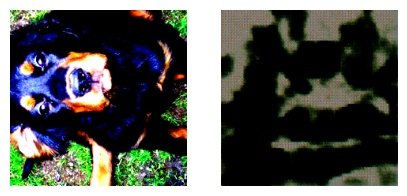

In [11]:
encoder.eval()
decoder.eval()



dataiter = iter(train_dl)
image, label = next(dataiter)

enc_out = encoder(image)
dec = decoder(enc_out)

figure = plt.figure(figsize=(1, 2))
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1) # subplot indices begin at 1, not 0
plt.axis('off')
plt.imshow(torch.transpose(image[1].detach(), 0, 2))
plt.subplot(1, 2, 2) # subplot indices begin at 1, not 0
plt.axis('off')
plt.imshow(torch.transpose(dec[1].detach(), 0, 2))

